# Modelos de regressão para séries temporal


In [1]:
import pandas as pd

In [12]:
df = pd.read_csv("data_updated.csv")
df

,week,volume,inv,users
0,2022-10-31,0.38,1.609882,6.500
1,2022-11-07,0.47,1.880548,7.061
2,2022-11-14,0.32,2.297810,5.875
3,2022-11-21,1.69,5.623875,24.238
4,2022-11-28,1.23,1.473418,7.648
...,...,...,...,...
152,2025-09-29,20.33,1.144344,9.575
153,2025-10-06,14.50,0.520285,4.504
154,2025-10-13,17.89,0.837998,7.296
155,2025-10-20,24.52,1.422242,12.458


In [13]:
# forecast_volume_regression.py
# Requer: pandas, numpy, statsmodels, matplotlib, scikit-learn
# Exemplo: pip install pandas numpy statsmodels matplotlib scikit-learn

import io
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

df['t'] = np.arange(1, len(df) + 1)       # tendência (t)
df.set_index('week', inplace=True)
# Garanta que o índice seja datetime
df.index = pd.to_datetime(df.index)


# -------------- Split treino/test (time-based) --------------
test_size = 4   # últimas 3 observações como teste (mude se desejar)
train = df.iloc[:-test_size].copy()
test = df.iloc[-test_size:].copy()

# -------------- Modelo 1: Regressão simples (volume ~ t) --------------
X_train_s = sm.add_constant(train['t'])
model_simple = sm.OLS(train['volume'], X_train_s).fit()

X_test_s = sm.add_constant(test['t'])
pred_test_simple = model_simple.get_prediction(X_test_s).summary_frame(alpha=0.05)  # 95% PI

# Forecast h passos à frente (só com t)
h = 4
last_t = df['t'].iloc[-1]
future_t = np.arange(last_t + 1, last_t + 1 + h)
X_future_s = sm.add_constant(future_t)
pred_future_simple = model_simple.get_prediction(X_future_s).summary_frame(alpha=0.05)


In [15]:

# -------------- Modelo 2: Regressão múltipla (volume ~ inv + users + t) --------------
# Observação importante: para prever mais à frente precisamos de inv/users futuros.
# Aqui usamos a suposição simples: inv e users futuros = último valor observado.
X_train_m = sm.add_constant(train[['inv', 'users', 't']])
model_multi = sm.OLS(train['volume'], X_train_m).fit()

X_test_m = sm.add_constant(test[['inv', 'users', 't']])
pred_test_multi = model_multi.get_prediction(X_test_m).summary_frame(alpha=0.05)

# Construir covariáveis futuras (assumindo inv/users constantes no último valor)
last_inv = df['inv'].iloc[-1]
last_users = df['users'].iloc[-1]
future_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=7), periods=h, freq='W-MON')
future_df = pd.DataFrame({
    'inv': [last_inv]*h,
    'users': [last_users]*h,
    't': future_t
}, index=future_index)

# Garantir que exógena tem mesma coluna 'const' usada no modelo
X_future_m = future_df[['inv','users','t']].copy()
X_future_m.insert(0, 'const', 1.0)
# Reordenar colunas conforme o modelo (por segurança)
cols_expected = model_multi.model.exog_names
X_future_m = X_future_m[cols_expected]

pred_future_multi = model_multi.get_prediction(X_future_m).summary_frame(alpha=0.05)

# -------------- Métricas --------------
# rmse_simple = mean_squared_error(test['volume'], pred_test_simple['mean'], squared=False)
# rmse_multi = mean_squared_error(test['volume'], pred_test_multi['mean'], squared=False)
rmse_simple = mean_squared_error(test['volume'], pred_test_simple['mean']) ** 0.5
rmse_multi = mean_squared_error(test['volume'], pred_test_multi['mean']) ** 0.5


# -------------- Resultados (impressão compacta) --------------
print("RMSE (simples)  :", rmse_simple)
print("RMSE (múltiplo) :", rmse_multi)
print("\nResumo - modelo simples:\n", model_simple.summary())
print("\nResumo - modelo múltiplo:\n", model_multi.summary())

# Mostrar tabelas: observados vs preditos (teste)
results_test = test[['volume','inv','users','t']].copy()
results_test['pred_simple'] = pred_test_simple['mean'].values
results_test['pi_lower_simple'] = pred_test_simple['obs_ci_lower'].values
results_test['pi_upper_simple'] = pred_test_simple['obs_ci_upper'].values
results_test['pred_multi'] = pred_test_multi['mean'].values
results_test['pi_lower_multi'] = pred_test_multi['obs_ci_lower'].values
results_test['pi_upper_multi'] = pred_test_multi['obs_ci_upper'].values

print("\nObservado vs Predito (conjunto de teste):")
print(results_test)

print("\nPrevisão futura (simples, {} semanas):".format(h))
print(pred_future_simple[['mean','obs_ci_lower','obs_ci_upper']])

print("\nPrevisão futura (múltipla, {} semanas, assumindo inv/users constantes):".format(h))
print(pred_future_multi[['mean','obs_ci_lower','obs_ci_upper']])

RMSE (simples)  : 8.82415601339445
RMSE (múltiplo) : 8.07740866666893

Resumo - modelo simples:
                             OLS Regression Results                            
Dep. Variable:                 volume   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     349.9
Date:                Sun, 30 Nov 2025   Prob (F-statistic):           3.71e-41
Time:                        16:06:20   Log-Likelihood:                -358.88
No. Observations:                 153   AIC:                             721.8
Df Residuals:                     151   BIC:                             727.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

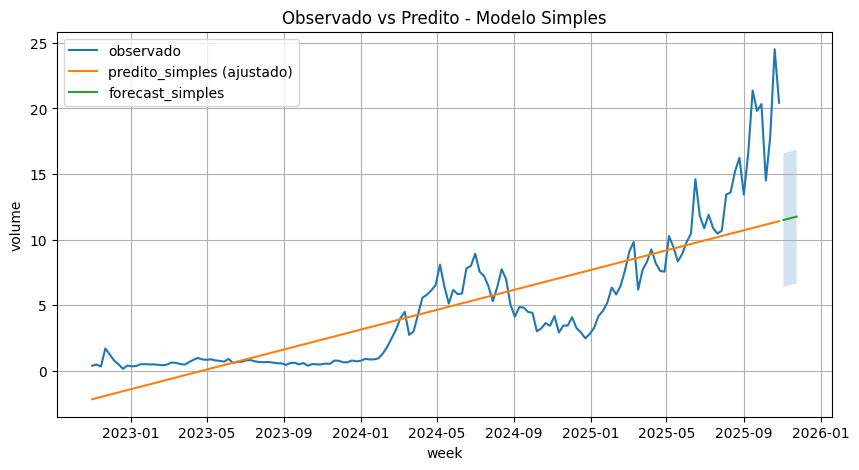

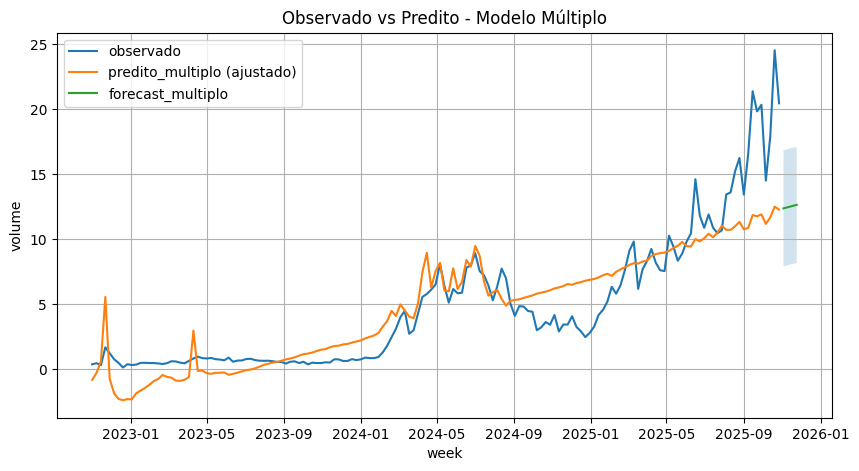


Sumários salvos em: summary_model_simple.txt e summary_model_multi.txt


In [16]:
# -------------- Plots --------------
plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')
all_X_s = sm.add_constant(df['t'])
all_pred_s = model_simple.get_prediction(all_X_s).summary_frame(alpha=0.05)
plt.plot(df.index, all_pred_s['mean'], label='predito_simples (ajustado)')
plt.plot(future_index, pred_future_simple['mean'], label='forecast_simples')
plt.fill_between(future_index, pred_future_simple['obs_ci_lower'], pred_future_simple['obs_ci_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Predito - Modelo Simples')
plt.xlabel('week')
plt.ylabel('volume')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df.index, df['volume'], label='observado')
all_X_m = sm.add_constant(df[['inv','users','t']])
all_pred_m = model_multi.get_prediction(all_X_m).summary_frame(alpha=0.05)
plt.plot(df.index, all_pred_m['mean'], label='predito_multiplo (ajustado)')
plt.plot(future_index, pred_future_multi['mean'], label='forecast_multiplo')
plt.fill_between(future_index, pred_future_multi['obs_ci_lower'], pred_future_multi['obs_ci_upper'], alpha=0.2)
plt.legend()
plt.title('Observado vs Predito - Modelo Múltiplo')
plt.xlabel('week')
plt.ylabel('volume')
plt.grid(True)
plt.show()

# (Opcional) salvar sumários
with open('summary_model_simple.txt','w') as f:
    f.write(model_simple.summary().as_text())
with open('summary_model_multi.txt','w') as f:
    f.write(model_multi.summary().as_text())

print("\nSumários salvos em: summary_model_simple.txt e summary_model_multi.txt")
